In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import scienceplots
import pandas as pd
from itertools import combinations
import pprint
from shapely.geometry import Polygon
plt.style.use(['science', 'grid'])

from utils import (
    load_dataset,
    get_images,
    transform_points,
    get_densities,
    predict,
    calculate_errors,
    get_result_dict,
    SCALING_FACTOR,
    plot_setup, 
    plot_setup_noised,
    plot_predictions,
    add_outlier
)

In [4]:
def filter_points(points, keys):
    filtered = {key: points[key] for key in keys}
    return filtered

def conduct_experiment(pv_img, tv_img, used_ref_points=None):
    # Load Data
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    img_pv, img_tv = get_images(pv_img, tv_img)
    
    if used_ref_points:
        reference_pts_pv = filter_points(reference_pts_pv, used_ref_points)
        reference_pts_tv = filter_points(reference_pts_tv, used_ref_points)
        
    # Transform Points to Homogeneous Numpy arrays
    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)
    # Calculate Homography
    h, _ = cv2.findHomography(
        reference_pts_pv_arr,
        reference_pts_tv_arr,
        # method = cv2.RANSAC,
        method = 0,
    )
    h_inv = np.linalg.inv(h)

    # Get Pixel Densities
    reference_densities = get_densities(reference_pts_tv_arr, h_inv)
    validation_densities = get_densities(validation_pts_tv_arr, h_inv)
    # Predict Points
    predicted_reference_pts_tv = predict(reference_pts_pv_arr, h)
    predicted_validation_pts_tv = predict(validation_pts_pv_arr, h)
    # Errors
    reference_errors = calculate_errors(predicted_reference_pts_tv, reference_pts_tv_arr)
    validation_errors = calculate_errors(predicted_validation_pts_tv, validation_pts_tv_arr)
    # Combine Results in Dictionary
    result_dict = {}
    reference_result_dict = get_result_dict(reference_pts_pv, reference_pts_tv_arr, predicted_reference_pts_tv, reference_errors, reference_densities, reference_pts_pv_arr)
    validation_result_dict = get_result_dict(validation_pts_pv, validation_pts_tv_arr, predicted_validation_pts_tv, validation_errors, validation_densities, reference_pts_pv_arr)
    result_dict['img'] = img_pv
    result_dict['reference'] = reference_result_dict
    result_dict['validation'] = validation_result_dict
    
    return result_dict    

In [5]:
def plot_points(result_dict, ax, color='whitesmoke', markersize=10):
    for name, pt in result_dict.items():
        ax.plot(pt['coordinates_pv'][0], pt['coordinates_pv'][1], marker='X', color=color, markersize=markersize)
    return ax

def plot_pixel_density(result_dict, ax, x_offset=-300, y_offset=200):
    for name, pt in result_dict.items():
        ax.annotate(
            f'{pt["pixel_density"]:.2f}', 
            xy=(pt['coordinates_pv'][0]+x_offset, pt['coordinates_pv'][1]+y_offset),
            bbox=dict(facecolor='steelblue', edgecolor='royalblue', boxstyle="round", alpha=0.8),
            color='white'
        )
    return ax

def plot_prediction(result_dict, ax, x_offset=-150, y_offset=200):
    errors = []
    for name, pt in result_dict.items():
        errors.append(pt["error"])
        ax.plot(pt['coordinates_tv'][0], pt['coordinates_tv'][1], marker='X', color='steelblue', markersize=8)  
        ax.plot(pt['predicted_coordinates_tv'][0], pt['predicted_coordinates_tv'][1], marker='X', color='cyan', markersize=8)
        ax.annotate(
            f'{pt["error"]:.2f}', 
            xy=(pt['coordinates_tv'][0]+x_offset, pt['coordinates_tv'][1]+y_offset),
            bbox=dict(facecolor='steelblue', edgecolor='royalblue', boxstyle="round", alpha=0.8),
            color='white'
        )
    ax.annotate(f'{np.mean(errors) / SCALING_FACTOR * 100 :.2f} cm', xy=(100, 150), color='white',
        bbox=dict(facecolor='black', edgecolor='white', boxstyle='round', alpha=0.8))
    return ax

In [6]:
images = ['DJI_0026', 'DJI_0029', 'DJI_0045', 'DJI_0053']

_, img_tv = get_images('DJI_0026', 'DJI_0017')

results = {}
for fname in images:
    _results = conduct_experiment(fname, 'DJI_0017')
    results[fname] = _results

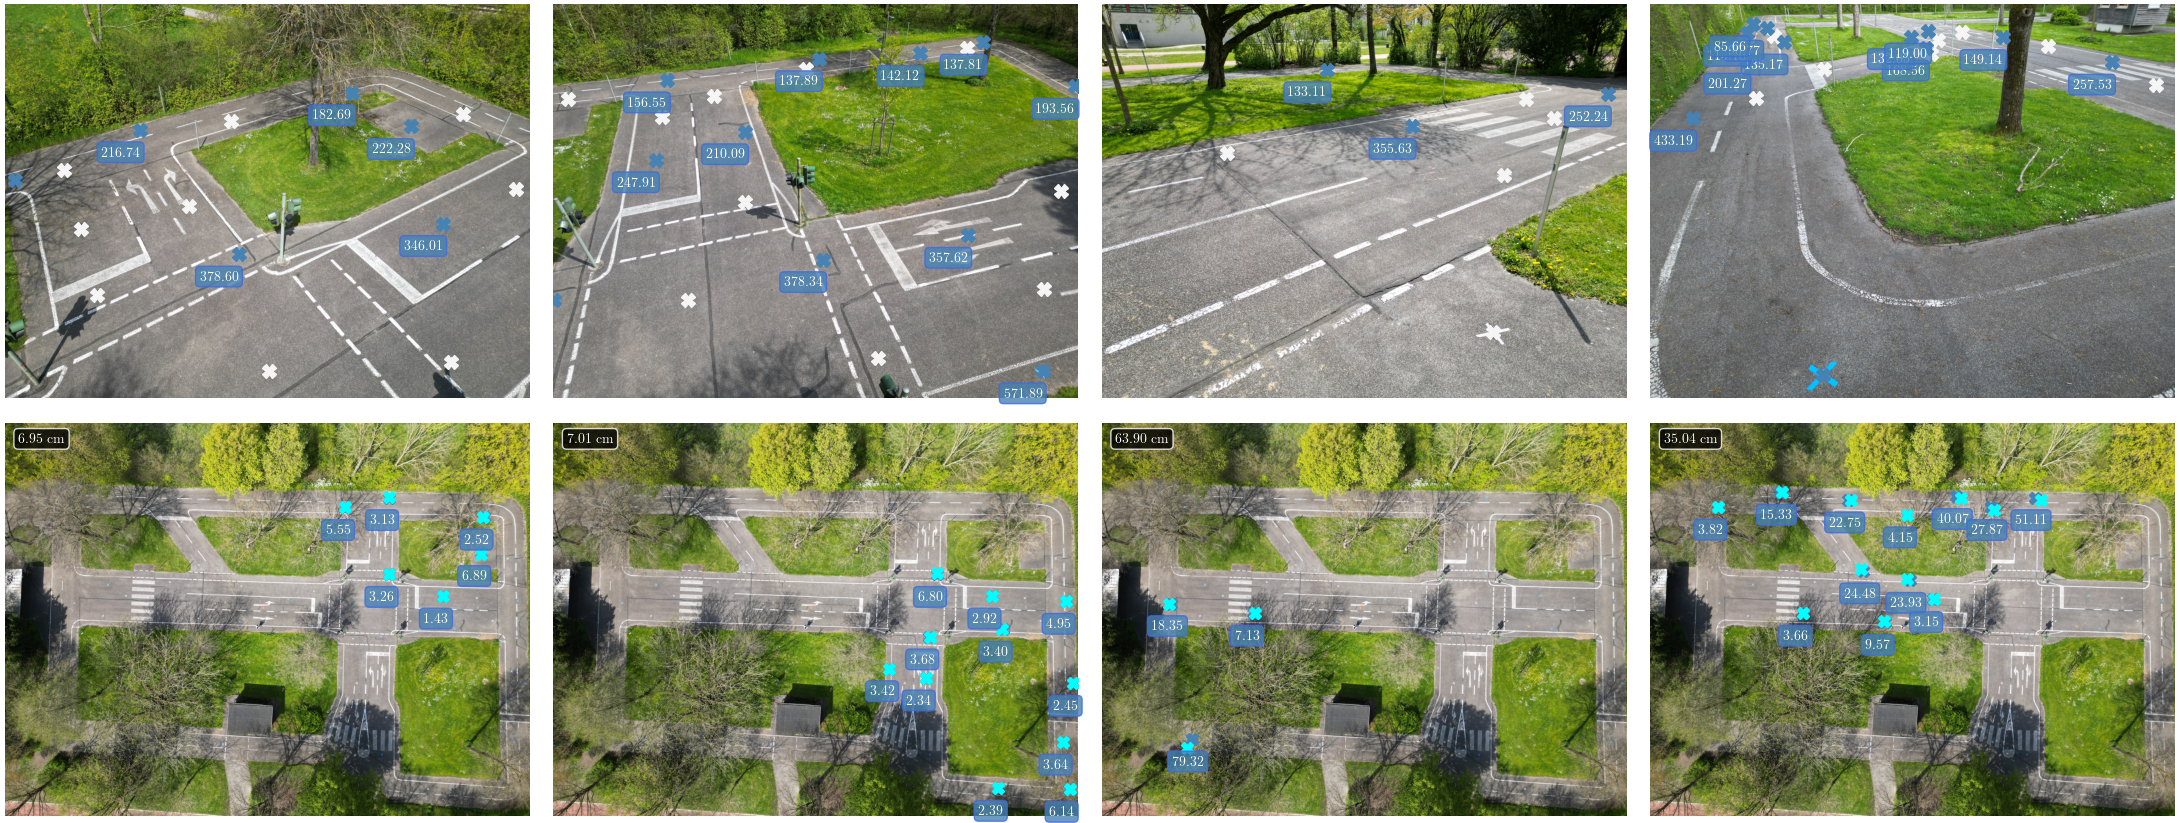

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(22, 8.8))

axs[0, 0].imshow(results['DJI_0026']['img'])
axs[0, 1].imshow(results['DJI_0029']['img'])
axs[0, 2].imshow(results['DJI_0045']['img'])
axs[0, 3].imshow(results['DJI_0053']['img'])

axs[1, 0].imshow(img_tv)
axs[1, 1].imshow(img_tv)
axs[1, 2].imshow(img_tv)
axs[1, 3].imshow(img_tv)

    
plot_points(results['DJI_0026']['reference'], axs[0, 0])
plot_points(results['DJI_0029']['reference'], axs[0, 1])
plot_points(results['DJI_0045']['reference'], axs[0, 2])
plot_points(results['DJI_0053']['reference'], axs[0, 3])

plot_points(results['DJI_0026']['validation'], axs[0, 0], 'steelblue')
plot_points(results['DJI_0029']['validation'], axs[0, 1], 'steelblue')
plot_points(results['DJI_0045']['validation'], axs[0, 2], 'steelblue')
plot_points(results['DJI_0053']['validation'], axs[0, 3], 'steelblue')

plot_pixel_density(results['DJI_0026']['validation'], axs[0, 0])
plot_pixel_density(results['DJI_0029']['validation'], axs[0, 1])
plot_pixel_density(results['DJI_0045']['validation'], axs[0, 2])
plot_pixel_density(results['DJI_0053']['validation'], axs[0, 3])

plot_prediction(results['DJI_0026']['validation'], axs[1, 0])
plot_prediction(results['DJI_0029']['validation'], axs[1, 1])
plot_prediction(results['DJI_0045']['validation'], axs[1, 2])
plot_prediction(results['DJI_0053']['validation'], axs[1, 3])

for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()
plt.savefig('perspectives.png', dpi=300)
plt.show()

In [30]:
# Average pixel densityb
def get_densities(img_name):
    densities = []
    for name, pt_dict in results[img_name]['validation'].items():
        densities.append(pt_dict['pixel_density'])
    return densities

def print_densities(name, densities):
    print(f'Density {name} -- mean: {np.mean(densities):.2f}, min: {np.min(densities):.2f}, max: {np.max(densities):.2f}, var: {np.var(densities):.2f}') # TODO MIN
    
    
densities_0026 = get_densities('DJI_0026')
densities_0029 = get_densities('DJI_0029')
densities_0045 = get_densities('DJI_0045')
densities_0053 = get_densities('DJI_0053')
densities_0053[0] = 500 # OUTLIER!

print_densities('0026', densities_0026)
print_densities('0029', densities_0029)
print_densities('0045', densities_0045)
print_densities('0053', densities_0053)

Density 0026 -- mean: 271.97, min: 182.69, max: 378.60, var: 5087.70
Density 0029 -- mean: 272.15, min: 137.81, max: 571.89, var: 20057.11
Density 0045 -- mean: 246.99, min: 133.11, max: 355.63, var: 8265.91
Density 0053 -- mean: 199.37, min: 85.66, max: 500.00, var: 16479.26
